<a href="https://colab.research.google.com/github/nimamt/machine_learning/blob/master/pytorch/reinforcement/NoisyDQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
!apt-get install -y xvfb

!pip install pygame gym==0.18 stable-baselines3 pytorch-lightning==1.6.0 pyvirtualdisplay

!pip install git+https://github.com/GrupoTuring/PyGame-Learning-Environment
!pip install git+https://github.com/lusob/gym-ple

Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.20.13-1ubuntu1~20.04.6).
The following package was automatically installed and is no longer required:
  libnvidia-common-510
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 21 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/GrupoTuring/PyGame-Learning-Environment to /tmp/pip-req-build-3ifn7wlj
  Running command git clone --filter=blob:none --quiet https://github.com/GrupoTuring/PyGame-Learning-Environment /tmp/pip-req-build-3ifn7wlj
  Resolved https://github.com/GrupoTuring/PyGame-Learning-Environment to commit 52ace013e3ea2fe5df08df98ec4dda902801e9df
  Preparing metadata (setup.py) ... done
Looking in indexes: https://pypi.org/s

In [22]:
from pyvirtualdisplay import Display
Display(visible=False, size=(1400, 900)).start()

In [23]:
import copy
import torch
import random
import gym
import gym_ple
import matplotlib

import numpy as np
import torch.nn.functional as F

import matplotlib.pyplot as plt
import matplotlib.animation as animation

from collections import deque, namedtuple
from IPython.display import HTML
from base64 import b64encode

from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import IterableDataset
from torch.optim import AdamW

from pytorch_lightning import LightningModule, Trainer

from gym.wrappers import TransformObservation

from stable_baselines3.common.atari_wrappers import MaxAndSkipEnv, WarpFrame


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
num_gpus = torch.cuda.device_count()

In [24]:
# Copied from: https://colab.research.google.com/github/deepmind/dm_control/blob/master/tutorial.ipynb#scrollTo=gKc1FNhKiVJX

def display_video(frames, framerate=30):
  height, width, _ = frames[0].shape
  dpi = 70
  orig_backend = matplotlib.get_backend()
  matplotlib.use('Agg')
  fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi), dpi=dpi)
  matplotlib.use(orig_backend)
  ax.set_axis_off()
  ax.set_aspect('equal')
  ax.set_position([0, 0, 1, 1])
  im = ax.imshow(frames[0])
  def update(frame):
    im.set_data(frame)
    return [im]
  interval = 1000/framerate
  anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                  interval=interval, blit=True, repeat=False)
  return HTML(anim.to_html5_video())

In [79]:
import math
from torch.nn.init import kaiming_uniform_, zeros_

class NoisyLinear(nn.Module):

  def __init__(self, in_features, out_features, sigma):
    super(NoisyLinear, self).__init__()

    self.w_mu = nn.Parameter(torch.empty((out_features, in_features)))
    self.w_sigma = nn.Parameter(torch.empty((out_features, in_features)))
    self.b_mu = nn.Parameter(torch.empty((out_features)))
    self.b_sigma = nn.Parameter(torch.empty((out_features)))

    kaiming_uniform_(self.w_mu, a=math.sqrt(5))    
    kaiming_uniform_(self.w_sigma, a=math.sqrt(5)) 
    zeros_(self.b_mu)
    zeros_(self.b_sigma)

  def forward(self, x, sigma=0.5):
    # Bigger sigma - More spread around - More noise
    
    if self.training:
      w_noise = torch.normal(0, sigma, size=self.w_mu.size()).to(device)
      b_noise = torch.normal(0, sigma, size=self.b_mu.size()).to(device)
      return F.linear(x, self.w_mu + self.w_sigma * w_noise, 
                    self.b_mu + self.b_sigma * b_noise)
    else:
      return F.linear(x, self.w_mu, self.b_mu)

In [80]:
class DQN(nn.Module):

  def __init__(self, hidden_size, obs_shape, n_actions, sigma=0.5):
    super().__init__()

    self.conv = nn.Sequential(
        nn.Conv2d(obs_shape[0], 64, kernel_size=3),
        nn.MaxPool2d(kernel_size=4),
        nn.ReLU(),
        nn.Conv2d(64, 64, kernel_size=3),
        nn.MaxPool2d(kernel_size=4),
        nn.ReLU(),
    )

    conv_out_size = self._get_conv_out(obs_shape)
    self.head = nn.Sequential(
        NoisyLinear(conv_out_size, hidden_size, sigma=sigma),
        nn.ReLU(),
        NoisyLinear(hidden_size, hidden_size, sigma=sigma),
        nn.ReLU(),
    )

    # Q(s, a) = V(s) + Adv(s, a)
    self.fc_value = NoisyLinear(hidden_size, 1, sigma=sigma)
    self.fc_adv = NoisyLinear(hidden_size, n_actions, sigma=sigma)

  def _get_conv_out(self, shape):
    conv_out = self.conv(torch.zeros(1, *shape))
    return int(np.prod(conv_out.size()))

  def forward(self, x):
    x = self.conv(x.float()).view(x.size()[0], -1) # First arg is batch_size
    x = self.head(x)
    adv = self.fc_adv(x)
    value = self.fc_value(x)
    return value + adv - torch.mean(adv, dim=1, keepdim=True)

We do not need an epsilon greedy method because the neural network will do the 
exploration.

In [81]:
def greedy(state, net):
  state = torch.tensor([state]).to(device)
  q_values = net(state)
  action = q_values.argmax(dim=-1)
  action = int(action.item())
  return action

In [82]:
class ReplayBuffer: 

  def __init__(self, capacity):
    super().__init__()
    self.buffer = deque(maxlen=capacity) # Will automatically delete old entries
    # to make room for new ones

    # stores priorites of each of the samples contained in the buffer
    self.priorities = deque(maxlen=capacity)

    self.capacity = capacity

    self.alpha = 1.0
    self.beta = 0.5
    self.max_priority = 0.0

  def __len__(self):
    return len(self.buffer)

  def append(self, experience):
    self.buffer.append(experience)
    self.priorities.append(self.max_priority)

  def update(self, index, priority):
    if priority > self.max_priority:
      self.max_priority = priority
    self.priorities[index] = priority 
  def sample(self, batch_size):
    probs = np.array(self.priorities, dtype=np.float64) + 1e-4
    probs = probs ** self.alpha
    probs = probs / probs.sum()

    weights = (self.__len__() * probs) ** -self.beta
    weights = weights / weights.max()

    idx = random.choices(range(self.__len__()), weights=probs, k=batch_size)
    sample = [(i, weights[i], *self.buffer[i]) for i in idx]    
    return sample

In [83]:
class RLDataset(IterableDataset):

  def __init__(self, buffer, sample_size=200):
    self.buffer = buffer
    self.sample_size = sample_size

  def __iter__(self):
    for experience in self.buffer.sample(self.sample_size):
      yield experience

In [84]:
class RunningMeanStd:
    # https://en.wikipedia.org/wiki/Algorithms_for_calculating_variance#Parallel_algorithm
    def __init__(self, epsilon=1e-4, shape=()):
        self.mean = np.zeros(shape, "float64")
        self.var = np.ones(shape, "float64")
        self.count = epsilon

    def update(self, x):
        batch_mean = np.mean(x, axis=0)
        batch_var = np.var(x, axis=0)
        batch_count = x.shape[0]
        self.update_from_moments(batch_mean, batch_var, batch_count)

    def update_from_moments(self, batch_mean, batch_var, batch_count):
        self.mean, self.var, self.count = update_mean_var_count_from_moments(
            self.mean, self.var, self.count, batch_mean, batch_var, batch_count
        )


def update_mean_var_count_from_moments(
    mean, var, count, batch_mean, batch_var, batch_count
):
    delta = batch_mean - mean
    tot_count = count + batch_count

    new_mean = mean + delta * batch_count / tot_count
    m_a = var * count
    m_b = batch_var * batch_count
    M2 = m_a + m_b + np.square(delta) * count * batch_count / tot_count
    new_var = M2 / tot_count
    new_count = tot_count

    return new_mean, new_var, new_count


class NormalizeObservation(gym.core.Wrapper):
    def __init__(
        self,
        env,
        epsilon=1e-8,
    ):
        super().__init__(env)
        self.num_envs = getattr(env, "num_envs", 1)
        self.is_vector_env = getattr(env, "is_vector_env", False)
        if self.is_vector_env:
            self.obs_rms = RunningMeanStd(shape=self.single_observation_space.shape)
        else:
            self.obs_rms = RunningMeanStd(shape=self.observation_space.shape)
        self.epsilon = epsilon

    def step(self, action):
        obs, rews, dones, infos = self.env.step(action)
        if self.is_vector_env:
            obs = self.normalize(obs)
        else:
            obs = self.normalize(np.array([obs]))[0]
        return obs, rews, dones, infos

    def reset(self, **kwargs):
        return_info = kwargs.get("return_info", False)
        if return_info:
            obs, info = self.env.reset(**kwargs)
        else:
            obs = self.env.reset(**kwargs)
        if self.is_vector_env:
            obs = self.normalize(obs)
        else:
            obs = self.normalize(np.array([obs]))[0]
        if not return_info:
            return obs
        else:
            return obs, info

    def normalize(self, obs):
        self.obs_rms.update(obs)
        return (obs - self.obs_rms.mean) / np.sqrt(self.obs_rms.var + self.epsilon)


class NormalizeReward(gym.core.Wrapper):
    def __init__(
        self,
        env,
        gamma=0.99,
        epsilon=1e-8,
    ):
        super().__init__(env)
        self.num_envs = getattr(env, "num_envs", 1)
        self.is_vector_env = getattr(env, "is_vector_env", False)
        self.return_rms = RunningMeanStd(shape=())
        self.returns = np.zeros(self.num_envs)
        self.gamma = gamma
        self.epsilon = epsilon

    def step(self, action):
        obs, rews, dones, infos = self.env.step(action)
        if not self.is_vector_env:
            rews = np.array([rews])
        self.returns = self.returns * self.gamma + rews
        rews = self.normalize(rews)
        self.returns[dones] = 0.0
        if not self.is_vector_env:
            rews = rews[0]
        return obs, rews, dones, infos

    def normalize(self, rews):
        self.return_rms.update(self.returns)
        return rews / np.sqrt(self.return_rms.var + self.epsilon)

In [85]:
env = gym_ple.make('Catcher-v0')

In [86]:
obs = env.reset()
obs.shape

(64, 64, 3)

In [87]:
env.observation_space, env.action_space

(Box(0, 255, (64, 64, 3), uint8), Discrete(3))

In [88]:
obs = env.reset()

for i in range(10):
  obs, _, _, _ = env.step(env.action_space.sample())

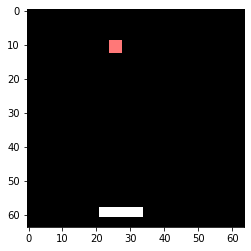

In [89]:
plt.imshow(obs)

In [90]:
def create_environment(env_name):
  env = gym_ple.make(env_name)
  env = MaxAndSkipEnv(env)
  env = WarpFrame(env, height=42, width=42)
  env = TransformObservation(env, lambda x: x.swapaxes(-1, 0))
  env.observation_space = gym.spaces.Box(low=0, high=255, shape=(1,42,42), dtype=np.float32)
  env = NormalizeObservation(env)
  env = NormalizeReward(env)
  return env

In [91]:
class DeepQLearning(LightningModule):

  def __init__(self, env_name, policy=greedy, capacity=100_000, 
               batch_size=256, lr=1e-3, hidden_size=128, gamma=0.99, 
               loss_fn=F.smooth_l1_loss, optim=AdamW, samples_per_epoch=10_000, 
               sync_rate=10, a_start=0.5, a_end=0.0, a_last_episode=100,
               b_start=0.4, b_end=1.0, b_last_episode=100, sigma=0.5):
    
    super().__init__()
    self.env = create_environment(env_name)

    obs_size = self.env.observation_space.shape
    n_actions = self.env.action_space.n

    self.q_net = DQN(hidden_size, obs_size, n_actions, sigma)

    # A copy that will be used to compute stable targets
    # Will update the values in this copy every sync_rate epochs
    self.target_q_net = copy.deepcopy(self.q_net) 

    self.policy = policy
    self.buffer = ReplayBuffer(capacity=capacity)

    self.save_hyperparameters()

    while len(self.buffer) < self.hparams.samples_per_epoch:
      print(f"{len(self.buffer)} samples in experience buffer. Filling...")
      self.play_episode()

  @torch.no_grad() # We have a policy
  # If we dont include this, action will participate in the learning process
  def play_episode(self, policy=None):
    state = self.env.reset()
    done = False

    while not done:
      if policy:
        action = policy(state, self.q_net)
      else:
        action = self.env.action_space.sample()
      next_state, reward, done, info = self.env.step(action)
      exp = (state, action, reward, done, next_state)
      self.buffer.append(exp)
      state = next_state

  def forward(self, x):
    return self.q_net(x)

  def configure_optimizers(self):
    q_net_optimizer = self.hparams.optim(self.q_net.parameters(), 
                                         lr=self.hparams.lr)
    return [q_net_optimizer] # We might have multiple neural networks, hence
                             # multiple optimizers

  def train_dataloader(self):
    dataset = RLDataset(self.buffer, self.hparams.samples_per_epoch)
    dataloader = DataLoader(
        dataset=dataset,
        batch_size=self.hparams.batch_size
    )
    return dataloader

  def training_step(self, batch, batch_idx):
    indices, weights, states, actions, rewards, dones, next_states = batch
    weights = weights.unsqueeze(1)
    actions = actions.unsqueeze(1)
    rewards = rewards.unsqueeze(1)
    dones = dones.unsqueeze(1)

    # Gather on the first dimension, the values of the actions taken
    state_action_values = self.q_net(states).gather(1, actions)

    # DELETED
    #next_action_values, _ = self.target_q_net(next_states).max(dim=1,
    #                                                           keepdim=True)
    # DELETED
    
    # ADDED
    with torch.no_grad():
      # Selects the action to be taken
      _, next_actions = self.q_net(next_states).max(dim=1, keepdim=True)
      # Estimates the value of those actions
      next_action_values = self.target_q_net(next_states).gather(1, next_actions)
      # ADDED
      
      # It will give estimated by default (the real result is 0.0, and we know this)
      next_action_values[dones] = 0.0 

    expected_state_action_values = rewards + self.hparams.gamma * next_action_values

    # Compute the priorities and update
    td_errors = (state_action_values - expected_state_action_values).abs().detach()

    for idx, e in zip(indices, td_errors):
      self.buffer.update(idx, e.cpu().item())

    # Compute the weighted loss function
    # reduction = 'none' because the shape of weights is (batch_size, 1)
    loss = weights * self.hparams.loss_fn(state_action_values, expected_state_action_values, reduction='none')
    loss = loss.mean()

    self.log('episode/Q-error', loss)
    return loss

  def training_epoch_end(self, outputs):
    # Decreasing as we go forward    
    alpha = max(
        self.hparams.a_end,
        self.hparams.a_start - self.current_epoch / self.hparams.a_last_episode
    )
    beta = max(
        self.hparams.b_end,
        self.hparams.b_start - self.current_epoch / self.hparams.b_last_episode
    )
    self.buffer.alpha = alpha
    self.buffer.beta = beta

    self.play_episode(policy=self.policy)
    # RecordStatistics keeps data in return_queue
    self.log('episode/Return', self.env.unwrapped.game_state.score())

    # The targets would be more stable after this
    if self.current_epoch % self.hparams.sync_rate == 0:
      self.target_q_net.load_state_dict(self.q_net.state_dict())

In [92]:
!rm -r /content/lightning_logs/
!rm -r /content/videos/

rm: cannot remove '/content/videos/': No such file or directory


In [96]:
# %load_ext tensorboard
# %tensorboard --logdir /content/lightning_logs/

In [94]:
algo = DeepQLearning(
    'Catcher-v0',
    lr=5e-4,
    hidden_size=512,
    capacity=10_000,
    sigma=0.5,
    samples_per_epoch=1_000,
    a_last_episode=1_200,
    b_last_episode=1_200)

trainer = Trainer(
    gpus=num_gpus,
    max_epochs=2_000,
    log_every_n_steps=1
)

trainer.fit(algo)

0 samples in experience buffer. Filling...
28 samples in experience buffer. Filling...
65 samples in experience buffer. Filling...
113 samples in experience buffer. Filling...
157 samples in experience buffer. Filling...
204 samples in experience buffer. Filling...
242 samples in experience buffer. Filling...
271 samples in experience buffer. Filling...
315 samples in experience buffer. Filling...
372 samples in experience buffer. Filling...
434 samples in experience buffer. Filling...
474 samples in experience buffer. Filling...
503 samples in experience buffer. Filling...
532 samples in experience buffer. Filling...
561 samples in experience buffer. Filling...
597 samples in experience buffer. Filling...
624 samples in experience buffer. Filling...
663 samples in experience buffer. Filling...
700 samples in experience buffer. Filling...
737 samples in experience buffer. Filling...
775 samples in experience buffer. Filling...
813 samples in experience buffer. Filling...


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type | Params
--------------------------------------
0 | q_net        | DQN  | 830 K 
1 | target_q_net | DQN  | 830 K 
--------------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params
6.641     Total estimated model params size (MB)


840 samples in experience buffer. Filling...
869 samples in experience buffer. Filling...
899 samples in experience buffer. Filling...
943 samples in experience buffer. Filling...


Training: 0it [00:00, ?it/s]

<ipython-input-81-b44f22633f78>:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  state = torch.tensor([state]).to(device)
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/trainer.py:727: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [95]:
env = algo.env
policy = algo.policy
q_net = algo.q_net.cuda()
frames = []

for episode in range(10):
  done = False
  obs = env.reset()
  while not done:
    frames.append(env.render(mode='rgb_array'))
    action = policy(obs, env, q_net)
    obs, _, done, _ = env.step(action)

RuntimeError: ignored

In [ ]:
display_video(frames)